Epoch 1/20 complete, Loss: 224.2246
Epoch 2/20 complete, Loss: 103.0149
Epoch 3/20 complete, Loss: 77.6501
Epoch 4/20 complete, Loss: 63.3028
Epoch 5/20 complete, Loss: 47.3332
Epoch 6/20 complete, Loss: 18.8402
Epoch 7/20 complete, Loss: 7.1968
Epoch 8/20 complete, Loss: 5.6177
Epoch 9/20 complete, Loss: 3.7071
Epoch 10/20 complete, Loss: 3.5209
Epoch 11/20 complete, Loss: 2.4319
Epoch 12/20 complete, Loss: 2.1320
Epoch 13/20 complete, Loss: 1.7934
Epoch 14/20 complete, Loss: 1.6472
Epoch 15/20 complete, Loss: 1.8930
Epoch 16/20 complete, Loss: 1.9758
Epoch 17/20 complete, Loss: 1.5551
Epoch 18/20 complete, Loss: 1.6613
Epoch 19/20 complete, Loss: 1.8195
Epoch 20/20 complete, Loss: 1.9083
              precision    recall  f1-score   support

 Agriculture       0.98      0.97      0.98       146
     Airport       0.93      0.94      0.94       146
       Beach       0.97      0.99      0.98       153
        City       0.98      0.98      0.98       170
      Desert       0.94      0

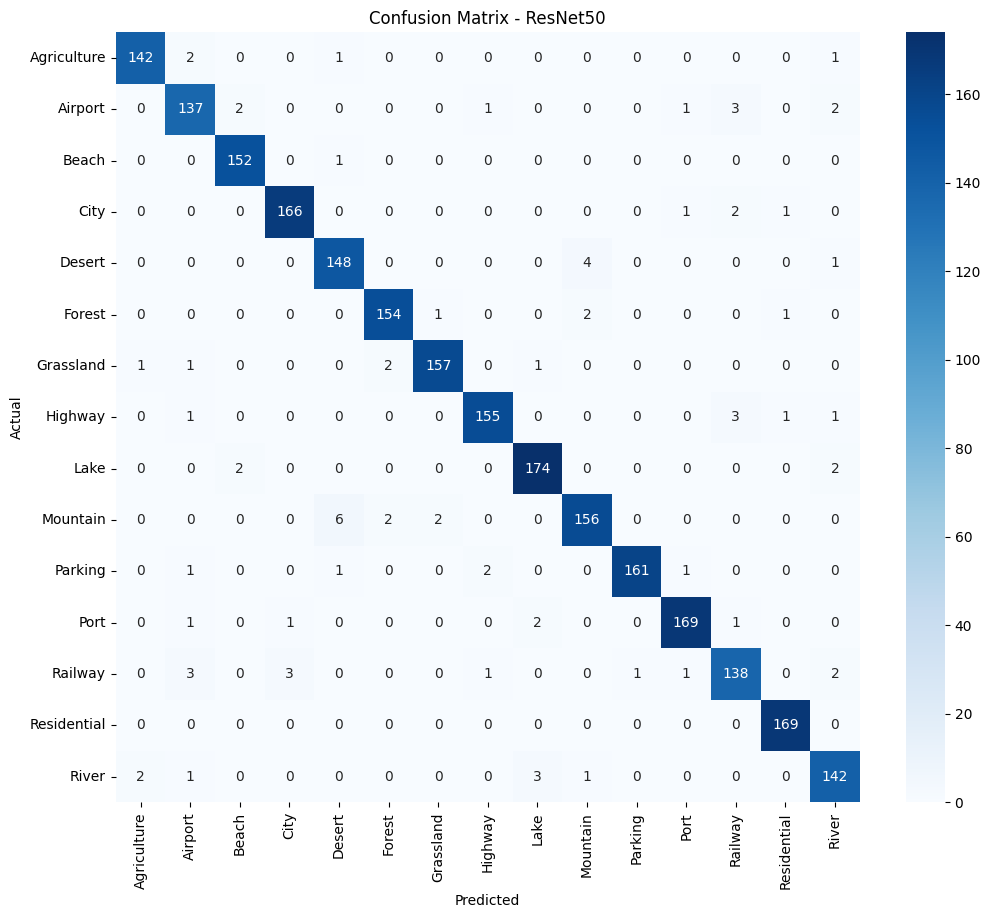

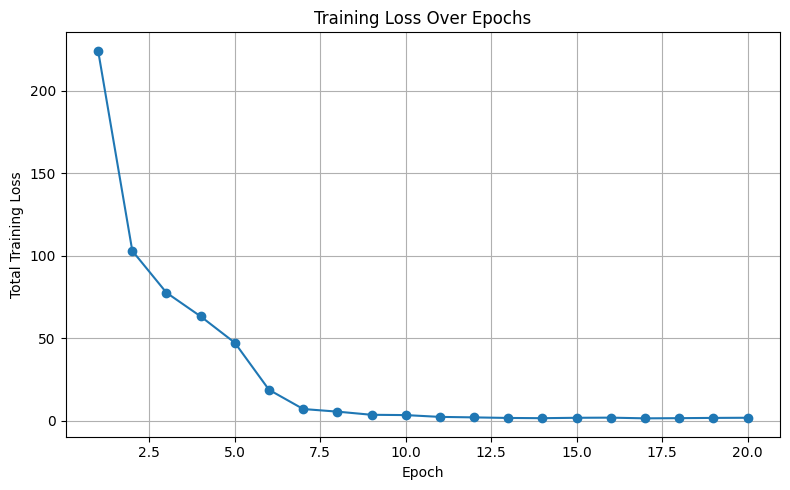

In [4]:
import os, torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

# Download dataset from Kaggle Hub
root_path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
data_path = os.path.join(root_path, "Aerial_Landscapes")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-50 and modify final layer
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 15)
)
model = model.to(device)

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
test_transform = weights.transforms()

# Load dataset
full_dataset = datasets.ImageFolder(data_path, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Track training loss
train_losses = []

# Training loop
for epoch in range(20):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    train_losses.append(running_loss)
    print(f"Epoch {epoch+1}/20 complete, Loss: {running_loss:.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification metrics
class_names = full_dataset.classes
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet50")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot training loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Total Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
